In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import datetime
import os
import gmaps
import gmaps.datasets
from mapsplotlib import mapsplot as mplt
from config import gkey
mplt.register_api_key(api_key=gkey)
from pprint import pprint

# Import API key
#from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

#Input Files (from cleandata)
facilities_file = "../data/cleandata/facilities.csv"
us_population_file = "../data/cleandata/population.csv"
suicide_us_file = "../data/cleandata/master.csv"

#Output File (PNG)
output_us_suicide_vs_age = "../Images/us_suicide_vs_age_line.png"
output_facilities_vs_pop = "../Images/mh_facilities_vs_population.png"
path_out_internat = os.path.join("..", "Images", "internat_suic_sorted.png")
output_us_avg_vs_world_avg = "../Images/us_vs_world_line.png"


## Bar Chart: US facilities vs US Population by State


In [2]:
#Read Mental Health Facilities in the US, input into df
facilities_df = pd.read_csv(facilities_file)
print(facilities_df.count())

#Read US Census Bureau population data, input into df
pop_df = pd.read_csv(us_population_file)
print(pop_df.count())

name1        9614
name2        5379
city         9614
state        9614
zip          9614
latitude     9614
longitude    9614
dtype: int64
state         51
State Name    51
Population    51
dtype: int64


In [3]:
# Merge two dataframes using an inner join
merge_table = pd.merge(facilities_df, pop_df, on="state", how='inner')
merge_table.head()

,name1,name2,city,state,zip,latitude,longitude,State Name,Population
0,Sheltering Harbour,NaN,Spring,TX,77379,30.031183,-95.489886,Texas,28701845
1,Cypress Creek Hospital,NaN,Houston,TX,77090,30.024661,-95.444850,Texas,28701845
2,Intracare North Hospital,NaN,Houston,TX,77090,30.023827,-95.440085,Texas,28701845
3,Tomball Regional Medical Center,Senior Care Behavioral Health,Tomball,TX,77375,30.087405,-95.623617,Texas,28701845
4,Unity Childrens Home,Trickey Road Location,Houston,TX,77067,29.956039,-95.445391,Texas,28701845


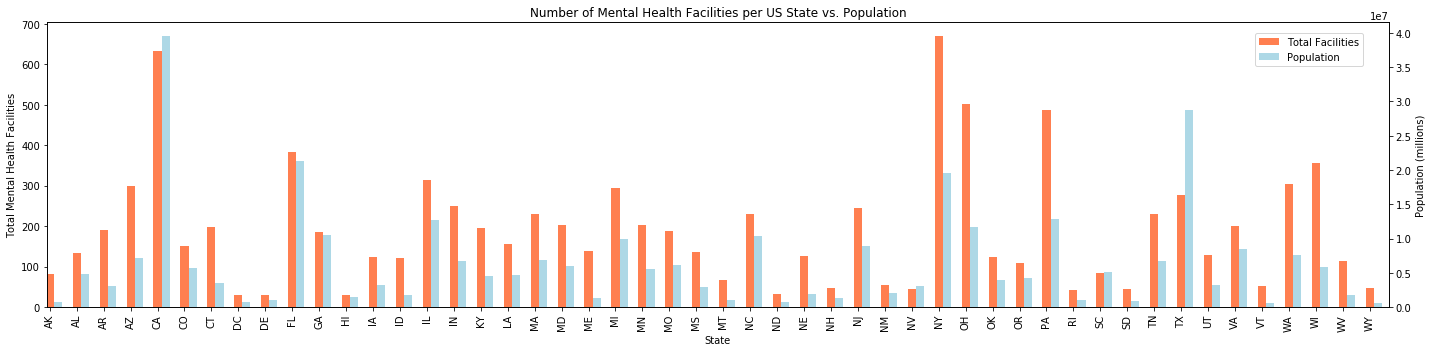

In [4]:
#Group merged dt by state so as to plot the bar chart by state
facilities_count_by_state = merge_table.groupby('state').agg({'name1':'count','Population':'mean'})
facilities_count_by_state.rename(columns={"name1":"Total Facilities"}, inplace=True)
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

facilities_count_by_state['Total Facilities'].plot(kind='bar', color='coral', ax=ax, figsize=(20,5), position=1, align='edge', width=0.3)
facilities_count_by_state.Population.plot(kind='bar', color='lightblue', ax=ax2, figsize=(20,5), position=0, align='edge', width=0.3)

ax.set_title("Number of Mental Health Facilities per US State vs. Population")
ax.set_xlabel("State")
ax.set_ylabel('Total Mental Health Facilities')
ax2.set_ylabel('Population (ten millions)')

fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.90))

# Save our graph and show the graph
plt.tight_layout()
plt.savefig(output_facilities_vs_pop)
plt.show()


## Line Graph: Age groups vs. Suicide Rate in the US

In [5]:
#Read Kaggle master suicide data, input into df
suicide_df = pd.read_csv(suicide_us_file)
#Filter for United States only
US_data = suicide_df [suicide_df['country'] == 'United States']
US_data.head()


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
26848,United States,1985,male,75+ years,2177,4064000,53.57,United States1985,0.841,"4,346,734,000,000",19693,G.I. Generation
26849,United States,1985,male,55-74 years,5302,17971000,29.50,United States1985,0.841,"4,346,734,000,000",19693,G.I. Generation
26850,United States,1985,male,25-34 years,5134,20986000,24.46,United States1985,0.841,"4,346,734,000,000",19693,Boomers
26851,United States,1985,male,35-54 years,6053,26589000,22.77,United States1985,0.841,"4,346,734,000,000",19693,Silent
26852,United States,1985,male,15-24 years,4267,19962000,21.38,United States1985,0.841,"4,346,734,000,000",19693,Generation X


In [6]:
US_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 26848 to 27219
Data columns (total 12 columns):
country               372 non-null object
year                  372 non-null int64
sex                   372 non-null object
age                   372 non-null object
suicides_no           372 non-null int64
population            372 non-null int64
suicides/100k pop     372 non-null float64
country-year          372 non-null object
HDI for year          120 non-null float64
 gdp_for_year ($)     372 non-null object
gdp_per_capita ($)    372 non-null int64
generation            372 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 37.8+ KB


In [7]:
#create a dt with only necessary columnns
US_data_sub=US_data[['year', 'age', 'suicides_no', 'population', 'suicides/100k pop']]
#gather data in groups by year and age range to plot trends
df_age_grp_by_yr=US_data_sub.groupby(['year','age'], as_index=False)
df_tot_by_yr=df_age_grp_by_yr['suicides_no'].sum()
df_tot_by_yr.head()

,year,age,suicides_no
0,1985,15-24 years,5121
1,1985,25-34 years,6376
2,1985,35-54 years,8158
3,1985,5-14 years,278
4,1985,55-74 years,6870


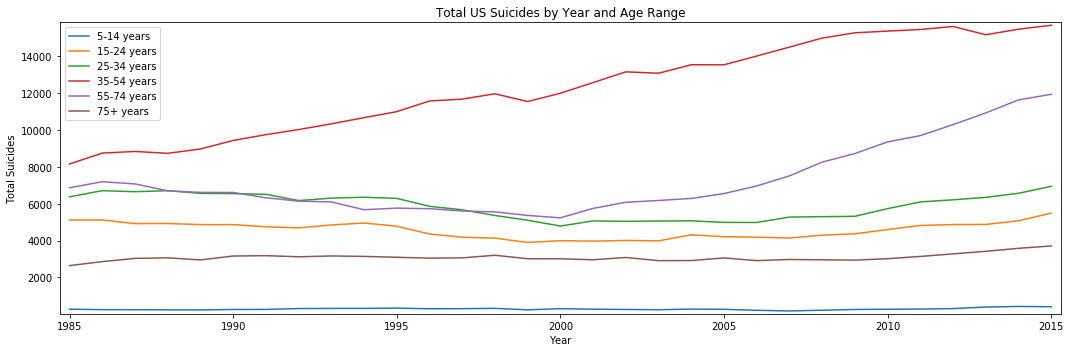

In [8]:
#Line graph age range vs. suicide rate in US
age_grp_1 = df_tot_by_yr.loc[df_tot_by_yr['age']=="5-14 years", 'suicides_no']
age_grp_2 = df_tot_by_yr.loc[df_tot_by_yr['age']=="15-24 years", 'suicides_no']
age_grp_3 = df_tot_by_yr.loc[df_tot_by_yr['age']=="25-34 years", 'suicides_no']
age_grp_4 = df_tot_by_yr.loc[df_tot_by_yr['age']=="35-54 years", 'suicides_no']
age_grp_5 = df_tot_by_yr.loc[df_tot_by_yr['age']=="55-74 years", 'suicides_no']
age_grp_6 = df_tot_by_yr.loc[df_tot_by_yr['age']=="75+ years", 'suicides_no']
time_line = df_tot_by_yr['year'].unique()

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(time_line, age_grp_1, label="5-14 years")
ax.plot(time_line, age_grp_2, label="15-24 years")
ax.plot(time_line, age_grp_3, label="25-34 years")
ax.plot(time_line, age_grp_4, label="35-54 years")
ax.plot(time_line, age_grp_5, label="55-74 years")
ax.plot(time_line, age_grp_6, label="75+ years")
ax.legend()

# Incorporate the other graph properties
plt.title(f"Total US Suicides by Year and Age Range" )
plt.ylabel("Total Suicides")
plt.xlabel("Year")
plt.margins(0.01)


fig.tight_layout()
fig.savefig(output_us_suicide_vs_age)

plt.show()

## Suicide Rates by Country, OECD

In [9]:
#  open data file from OECD, Organisation for Economic Co-operation and Development
path_in = os.path.join("..", "data", "MaybeData", "International", "DP_LIVE_21032019024128590.csv")
oecd_data = pd.read_csv(path_in)
oecd_df = pd.DataFrame(oecd_data)
oecd_df.head()
# each country may have multiple years, 1 line/year
# no breakout just total suicides per capita age-adjusted (good basis of comparison)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,SUICIDE,TOT,100000PER,A,2014,12.3,NaN
1,AUS,SUICIDE,TOT,100000PER,A,2015,12.8,NaN
2,AUT,SUICIDE,TOT,100000PER,A,2014,13.9,NaN
3,AUT,SUICIDE,TOT,100000PER,A,2015,12.9,NaN
4,AUT,SUICIDE,TOT,100000PER,A,2016,12.2,NaN


In [10]:
# len(oecd_df.groupby(["LOCATION"]).groups)     # 38 countries, 
# oecd_df.groupby('LOCATION').first()          # all have values for 2014
# oecd_df.groupby('LOCATION').last()          # some ONLY have data for 2014
# No population data or economica data, but a good overview comparing 2nd-1st world.
### Groupby to gather only 2014 data, since it is the only complete year. 
### Then sort by lowest to hightest suic rate. Set new index once sorted.
oecd_group = pd.DataFrame(oecd_df.groupby('LOCATION').first())
oecd_group = oecd_group.sort_values('Value')
oecd_group = oecd_group.reset_index()
oecd_group.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,ZAF,SUICIDE,TOT,100000PER,A,2014,1.2,NaN
1,TUR,SUICIDE,TOT,100000PER,A,2014,2.3,NaN
2,GRC,SUICIDE,TOT,100000PER,A,2014,4.7,NaN
3,COL,SUICIDE,TOT,100000PER,A,2014,4.9,NaN
4,MEX,SUICIDE,TOT,100000PER,A,2014,5.5,NaN


In [11]:
# The country codes are difficult to understand. And don't match the OECD members.
country_members = ["Australia","Austria""Belgium","Canada","Chile","Czech Republic",\
                   "Denmark","Estonia","Finland","France","Germany","Greece","Hungary",\
                   "Iceland","Ireland","Israël","Italy","Japan","Korea","Latvia","Lithuania"\
                   "Luxembourg","Mexico","Netherlands","New Zealand","Norway","Poland",\
                   "Portugal","Slovak Republic","Slovenia","Spain","Switzerland",
                   "Turkey","United Kingdom","United States"]
# len(country_members)                        # 36 countries... ZAF and which other are extra? 
# len(oecd_group.loc[:,"LOCATION"])         # 38 countries
print(*oecd_group.loc[:,"LOCATION"])
print(*country_members)
###  oecd_df is missing "Canada", "Latvia", "New Zealand", "United States"
###  oecd_df extras incl. "BRA", "COL", "CRI", "LVA", "ZAF"

ZAF TUR GRC COL MEX ISR BRA CRI ITA GBR ESP SVK PRT CHL NLD NOR IRL DNK DEU SWE LUX CHE AUS FRA CZE USA ISL AUT FIN POL BEL SVN EST JPN HUN LVA KOR LTU
Australia AustriaBelgium Canada Chile Czech Republic Denmark Estonia Finland France Germany Greece Hungary Iceland Ireland Israël Italy Japan Korea Latvia LithuaniaLuxembourg Mexico Netherlands New Zealand Norway Poland Portugal Slovak Republic Slovenia Spain Switzerland Turkey United Kingdom United States


In [12]:
# Convert 3-letter country codes > European names, the hard way.
countries = {"AUS":"Australia", "AUT":"Austria", "BEL":"Belgium", \
             "BRA":"Brazil", "CHE":"Switzerland", "CHL":"Chile", 
             "COL":"Columbia", "CRI":"Costa Rica", "CZE":"Czech Republic",\
             "DEU":"Germany", "DNK":"Denmark", "ESP":"Spain", \
             "EST":"Estonia", "FIN":"Finland", "FRA":"France", \
             "GBR":"United Kingdom", "GRC":"Greece", "HUN":"Hungary", \
             "IRL":"Ireland", "ISL":"Iceland", "ISR":"Israël", \
             "ITA":"Italy", "JPN":"Japan", "KOR":"Korea", \
             "LTU":"Lithuania", "LUX":"Luxembourg", "MEX":"Mexico", \
             "NLD":"Netherlands", "NOR":"Norway", "POL":"Poland", \
             "PRT":"Portugal", "SLV":"Slovak Republic", "SVN":"Slovenia", \
             "SWE":"Sweden", "TUR":"Turkey", "ZAF":"South Africa"}
oecd_group.replace(to_replace=countries, value=None, inplace=True)
oecd_countries = pd.DataFrame(oecd_group)
oecd_countries.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,South Africa,SUICIDE,TOT,100000PER,A,2014,1.2,NaN
1,Turkey,SUICIDE,TOT,100000PER,A,2014,2.3,NaN
2,Greece,SUICIDE,TOT,100000PER,A,2014,4.7,NaN
3,Columbia,SUICIDE,TOT,100000PER,A,2014,4.9,NaN
4,Mexico,SUICIDE,TOT,100000PER,A,2014,5.5,NaN


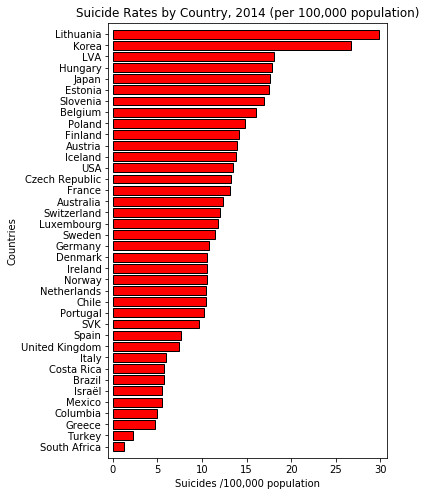

In [13]:
y_axis = np.arange(len(oecd_countries))
plt.figure(figsize=(5,8))
plt.barh(y_axis, oecd_countries["Value"], color='r', align="center", \
         edgecolor='k', linewidth=1)
plt.xlim(-0.5, (oecd_countries["Value"]).max()+1)
plt.ylim(-1, len(oecd_countries))
labels = oecd_countries.loc[:,"LOCATION"]
plt.yticks(y_axis, labels) 
plt.title("Suicide Rates by Country, 2014 (per 100,000 population)")
plt.xlabel("Suicides /100,000 population")
plt.ylabel("Countries")

plt.savefig(path_out_internat)
plt.show()


## Mental Health Facility locations on US map


In [14]:
facilities_df = pd.read_csv(facilities_file)
facilities_df.head()

,name1,name2,city,state,zip,latitude,longitude
0,Sheltering Harbour,NaN,Spring,TX,77379,30.031183,-95.489886
1,Cypress Creek Hospital,NaN,Houston,TX,77090,30.024661,-95.444850
2,Intracare North Hospital,NaN,Houston,TX,77090,30.023827,-95.440085
3,Tomball Regional Medical Center,Senior Care Behavioral Health,Tomball,TX,77375,30.087405,-95.623617
4,Unity Childrens Home,Trickey Road Location,Houston,TX,77067,29.956039,-95.445391


In [15]:
location = facilities_df[["latitude", "longitude"]]
location.head()

,latitude,longitude
0,30.031183,-95.489886
1,30.024661,-95.444850
2,30.023827,-95.440085
3,30.087405,-95.623617
4,29.956039,-95.445391


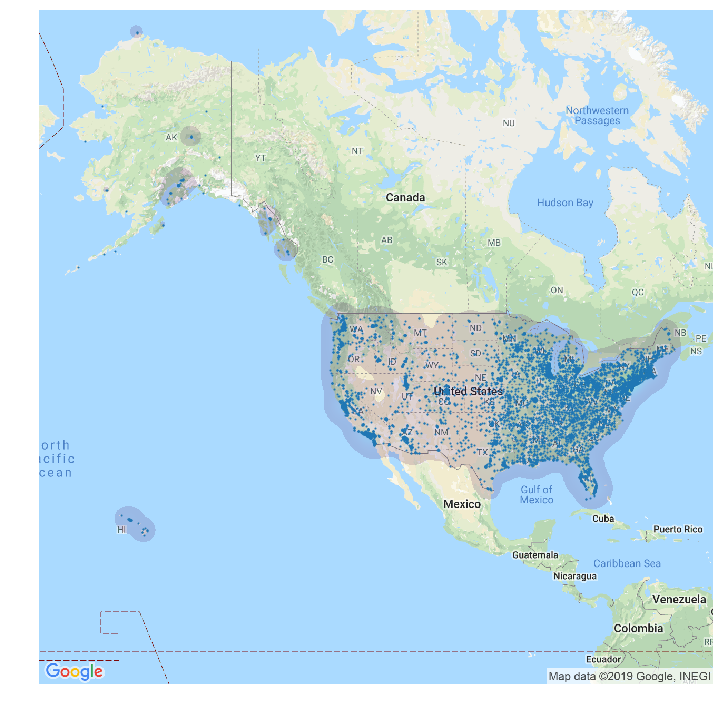

In [16]:
mplt.density_plot(location['latitude'], location['longitude'])

In [17]:
con_us=facilities_df[(facilities_df["state"]!= "HI")&(facilities_df["state"]!= "AK")]


location_one = con_us[["latitude", "longitude"]]

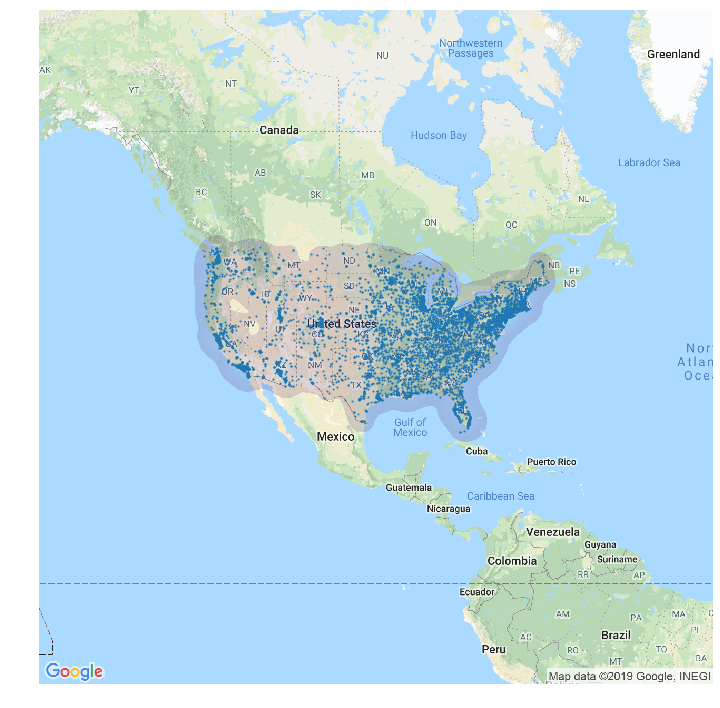

In [18]:
mplt.density_plot(con_us['latitude'] , con_us['longitude'])

In [19]:
I_dontknow =facilities_df[(facilities_df["state"]== "HI")&(facilities_df["state"]!= "AK")]
I_dontknow.head()

,name1,name2,city,state,zip,latitude,longitude
9583,Hawaii State/Dept of Health CAMHD,East Hawaii Family Guidance Center,Hilo,HI,96720,19.721549,-155.064722
9584,Hope Inc,NaN,Hilo,HI,96720,19.725357,-155.087798
9585,Hilo Medical Center,Hale Ho'ola Behavioral Health,Hilo,HI,96720,19.718245,-155.112746
9587,North Hawaii Adult MH Servs,Honokaa Clinic,Honokaa,HI,96727,20.077379,-155.462707
9588,North Hawaii Adult MH Servs,Waimea Clinic,Kamuela,HI,96743,20.023990,-155.662287


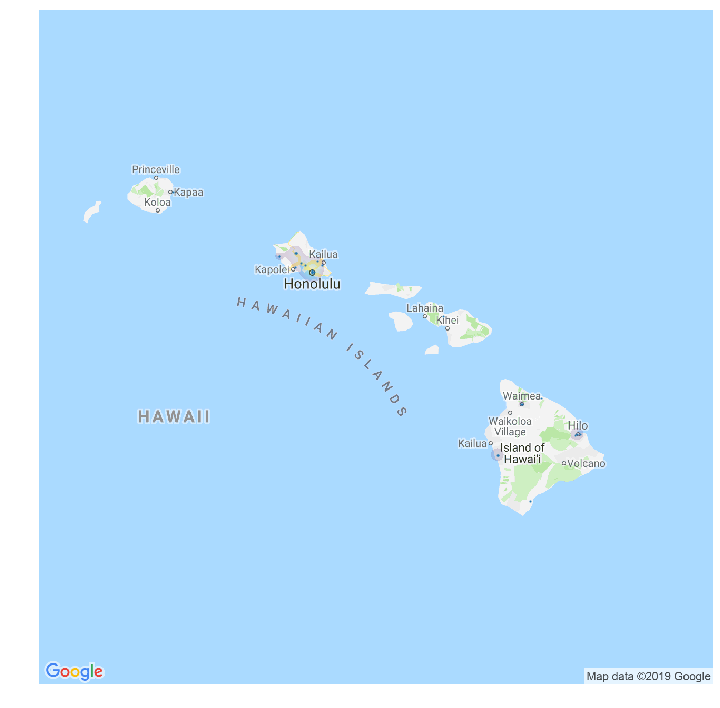

In [20]:
mplt.density_plot(I_dontknow['latitude'] ,I_dontknow['longitude'])

In [21]:
alaska =facilities_df[(facilities_df["state"]== "AK")&(facilities_df["state"]!= "HI")]
alaska.head()

,name1,name2,city,state,zip,latitude,longitude
9503,Metlakatla Indian Community,Willamootk Counseling Services,Metlakatla,AK,99926,55.129340,-131.576211
9504,Community Connections,NaN,Ketchikan,AK,99901,55.338278,-131.634657
9505,Residential Youth Care Inc,NaN,Ketchikan,AK,99901,55.350568,-131.676020
9506,Gateway Center for Human Services,Akeela Inc,Ketchikan,AK,99901,55.353986,-131.685082
9507,PeaceHealth Ketchikan Medical Center,NaN,Ketchikan,AK,99901,55.353657,-131.686635


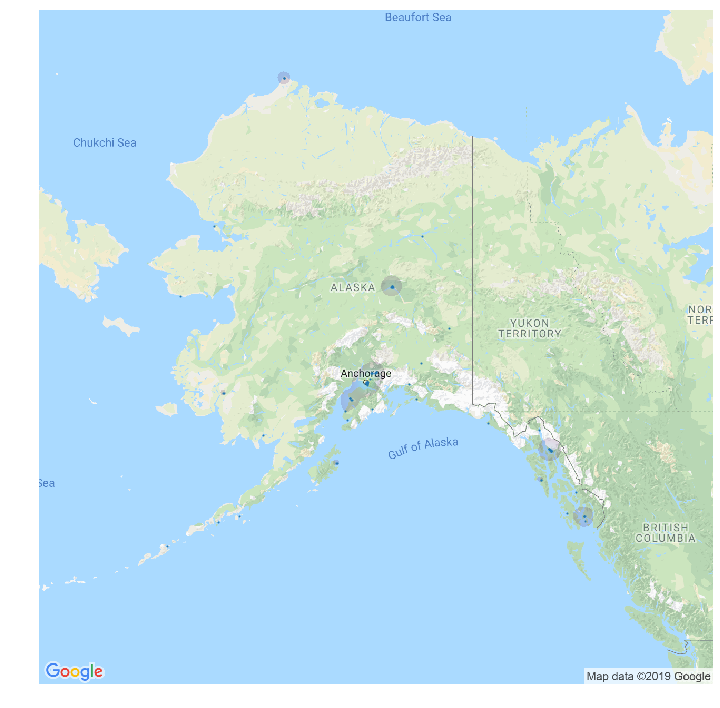

In [22]:
mplt.density_plot(alaska['latitude'] ,alaska['longitude'])

## US suicide rate vs World suicide rate

In [23]:
suicide_df = pd.read_csv(suicide_us_file)
#remove 2016 data b/c only there for some countries
suicide_new_df = suicide_df[suicide_df['year']!=2016]

summary_df = suicide_new_df.groupby(['country', 'year'], as_index=False).agg({'suicides/100k pop':'sum'})

summary_df.pivot(index='country', columns='year', values='suicides/100k pop')
# Set the 'Country Code' to be our index for easy referencing of rows
summary_df = summary_df.set_index("country")
# Collect the mean suicide rates for the world
average_suicide = summary_df.groupby('year').mean()
# Collect the years where data was collected
years = summary_df.year.unique()

#i have no idea why I can't get series returned just using the .loc; this is a workaround
x=summary_df.loc[['United States'], ["year", "suicides/100k pop"]].groupby('year')
us_average = x.mean()

fig = plt.figure(figsize=(10,3))

# Plot the world average as a line chart
world_avg, = plt.plot(sorted(years), average_suicide, color="blue", label="World Average" )

# Plot the unemployment values for a single country
country_one, = plt.plot(sorted(years), us_average, color="green",label='United States')

# Create a legend for our chart
plt.legend(handles=[world_avg, country_one], loc="best")
plt.title(f"US vs. World Suicide Rate" )
plt.ylabel("Suicides/100k Population")
plt.xlabel("Year")

# Show the chart
fig.tight_layout()
fig.savefig(output_us_avg_vs_world_avg)

plt.show()

NameError: name 'suicide_us' is not defined

## Next Chart: